# Importação

In [1]:
#Padrão
import pandas as pd
import numpy as np
import math 

# Visualização
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Machine Learning others
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA





In [2]:
dataset_treino = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos Portfólio/Regressão/Casas/train.csv')
dataset_teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos Portfólio/Regressão/Casas/test.csv')
y = dataset_treino['SalePrice']
ID_treino = dataset_treino['Id']
ID_teste = dataset_teste['Id']
dataset_treino.drop(['SalePrice', 'Id'],axis=1,inplace=True)
dataset_teste.drop('Id', axis=1, inplace=True)

# Engenharia de atributos


## Separação breve dos dados
- Aqui os dados vão ser separados entre númericos e alfabéticos
- Os atributos de dispersão serão separados 

In [3]:
treino_num = dataset_treino.select_dtypes(include=[np.number])
treino_cat = list(set(dataset_treino.columns) - set(treino_num))
teste_cat = dataset_teste.loc[:,treino_cat]
treino_cat = dataset_treino.loc[:,treino_cat]
teste_num = dataset_teste.select_dtypes(include=[np.number])

In [4]:

nomes = ['SF','Area','Porch','LotFrontage','Val']
var_quantitativas = []
for i in treino_num:
  o = 0
  for ii in nomes:
    if ii in i:
      if o == 0:
        var_quantitativas.append(i)
        o = 1
total = set(treino_num)
var_qualitativas = list(total - set(var_quantitativas))

tr_num_qual = treino_num.loc[:, var_qualitativas]
tr_num_quan = treino_num.loc[:, var_quantitativas]
te_num_qual = teste_num.loc[:, var_qualitativas]
te_num_quan = teste_num.loc[:, var_quantitativas]

## Dados numéricos

### <font color=lightblue>Dados quantitativos

<h3><font color=red> Tratar dados vazios

In [5]:
tr_num_quan.isnull().sum()
te_num_quan.isnull().sum()

LotFrontage      227
LotArea            0
MasVnrArea        15
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
dtype: int64

In [6]:
def imputer(df_tr, df_te):
  si = SimpleImputer(strategy='median')
  df_tr = pd.DataFrame(si.fit_transform(df_tr), columns=df_tr.columns)
  df_te = pd.DataFrame(si.fit_transform(df_te), columns=df_te.columns)
  # print(f' Vazios: treino: {df_tr.isnull().sum().sum()} teste: {df_te.isnull().sum().sum()}')
  return df_tr, df_te

tr_num_quan, te_num_quan = imputer(tr_num_quan, te_num_quan)

<h3><font color=red> Análise de dispersão

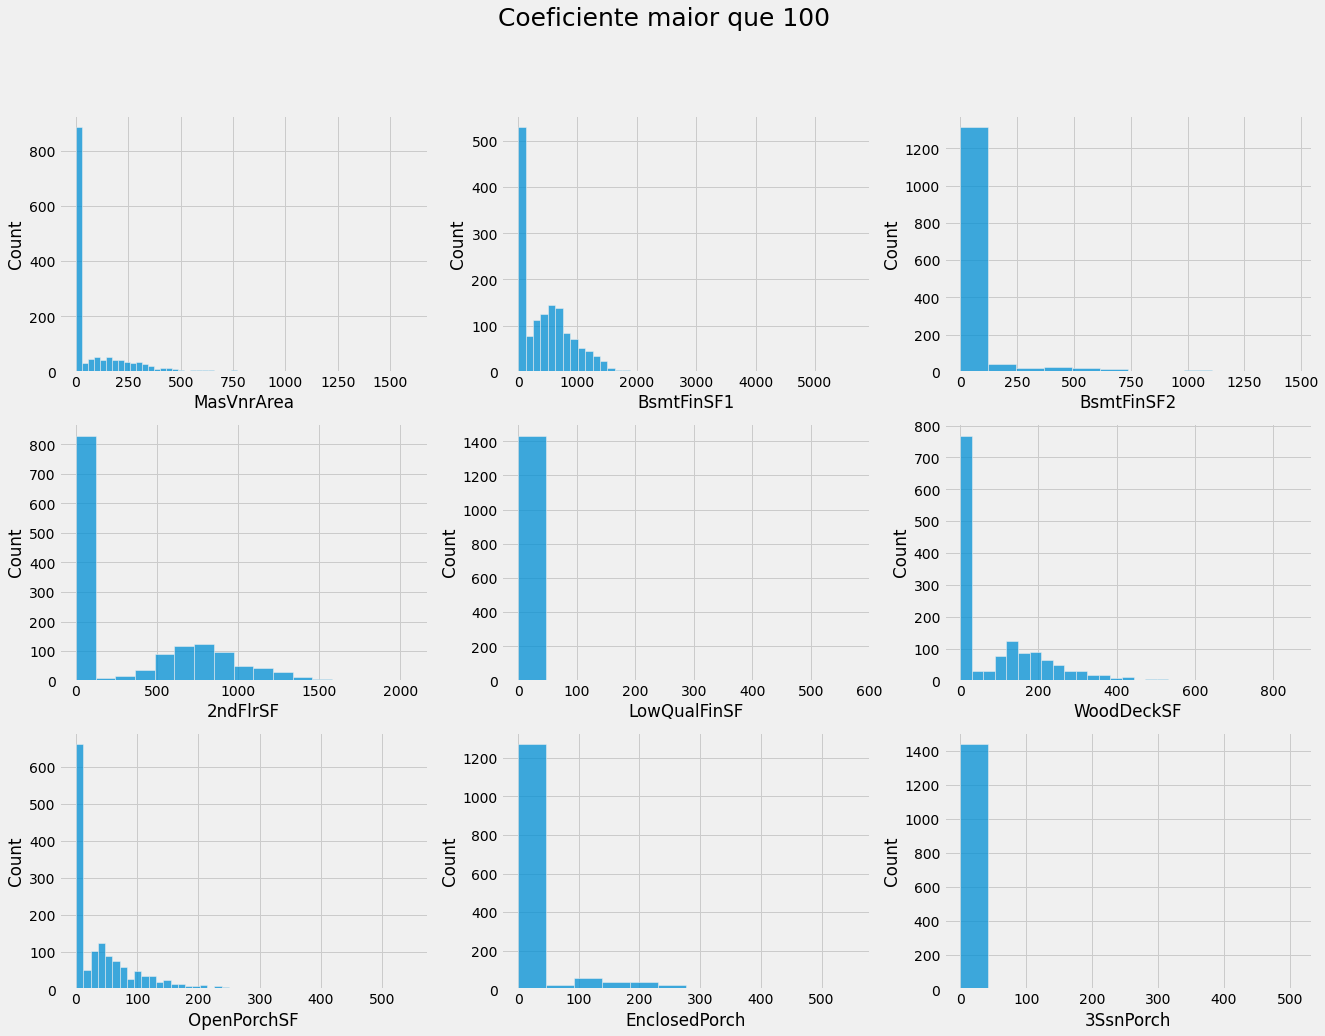

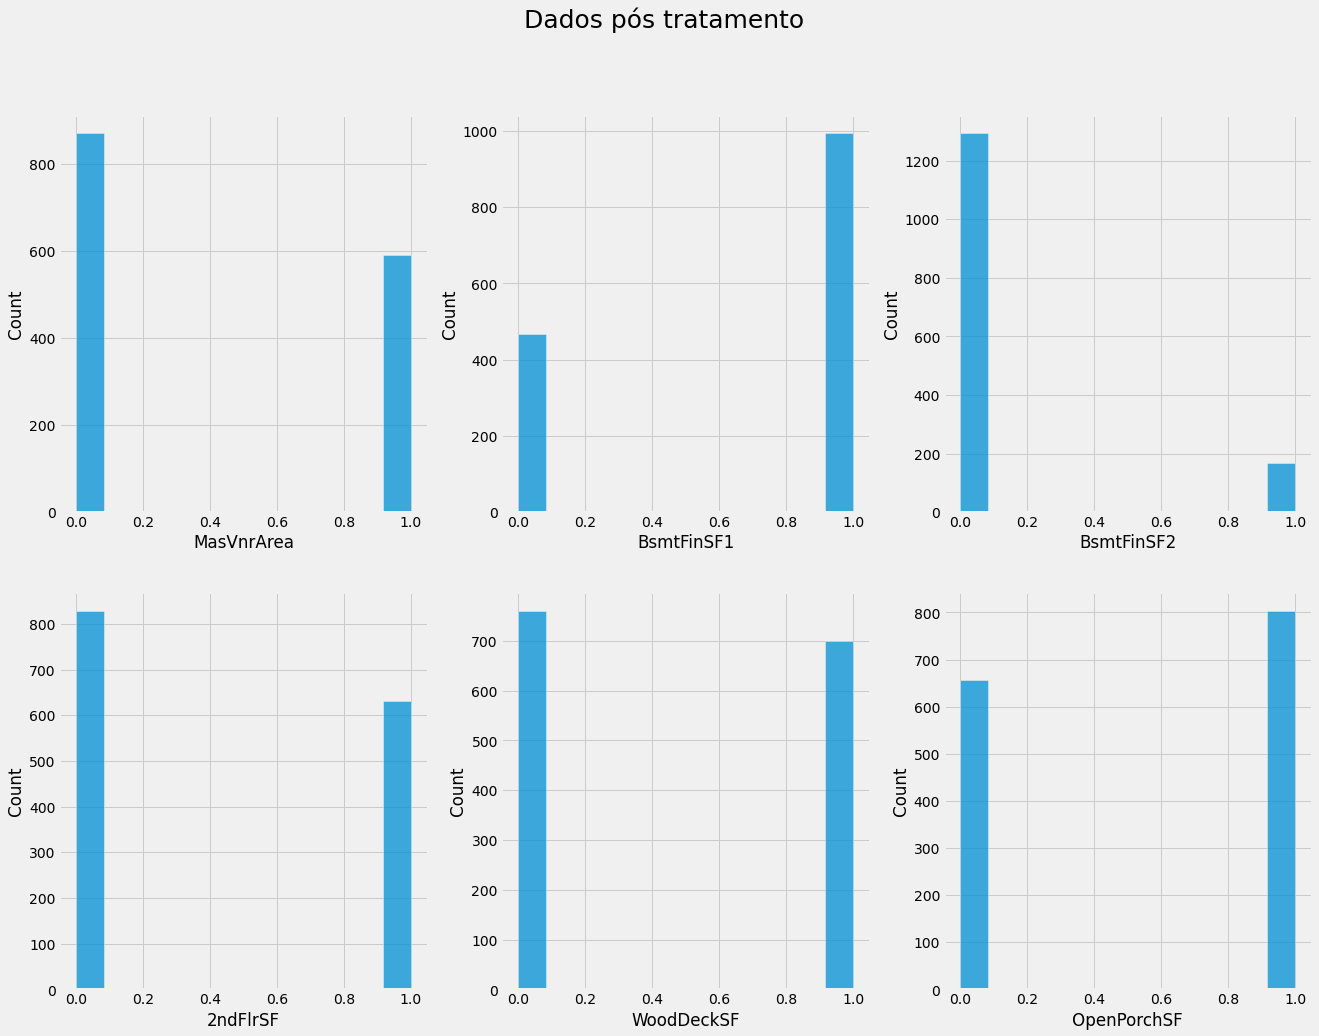

In [7]:
def visualizacao_dispersao(df_t, df_tee):
  df_tr = df_t.copy() 
  df_te = df_tee.copy()

  # Coeficiente de variação
  coef_acima_100, coef_abaixo_100 = [], []
  for i in df_tr:
    std = df_tr[i].std()
    media = df_tr[i].mean()
    coef_var = std/media
    if coef_var > 1:
      coef_acima_100.append(i)
    else:
      coef_abaixo_100.append(i)

  # Visualização dos acima de 100
  plt.style.use('fivethirtyeight')
  figura, ax = plt.subplots(3,3, figsize=(20,15))
  plt.suptitle('Coeficiente maior que 100', fontsize=25)
  for i,axe in zip(coef_acima_100, figura.axes):
    fg = sns.histplot(ax=axe, x=df_tr[i])
    
  # Transformação em binning
  binario, n_binario = [], []
  for i in coef_acima_100:
    bn = df_tr[i].value_counts()[0]/df_tr.shape[0]*100
    if bn >= 95:
      n_binario.append(i)
    else:
      binario.append(i)
  # Dropar dados não utilzados
  PCA = pd.concat([df_tr.loc[:,n_binario], df_te.loc[:,n_binario]], axis = 0) 
  df_tr =  df_tr.drop(n_binario, axis=1)
  df_te = df_te.drop(n_binario, axis=1)
  for i in binario:
    rt = df_tr[i].value_counts().index[0]
    df_tr.loc[df_tr[i] != rt, i] = 1
    df_te.loc[df_tr[i] != rt, i] = 1
    df_tr.loc[df_tr[i] != 1, i] = 0 
    df_te.loc[df_tr[i] != 1, i] = 0 

  # Visualização dos dados Binarizados
  print('')
  plt.style.use('fivethirtyeight')
  figura, ax = plt.subplots(2,3, figsize=(20,15))
  plt.suptitle('Dados pós tratamento', fontsize=25)
  for i,axe in zip(binario, figura.axes):
    fg = sns.histplot(ax=axe, x=df_tr[i])

  # Quantitativos
  df1 = df_tr.loc[:,coef_abaixo_100]
  df11 = df_te.loc[:,coef_abaixo_100]

  # Qualitativos
  df2 = df_tr.loc[:,binario]
  df22 = df_te.loc[:,binario]

  # Power transform para os dados terem uma distribuição normal

  df1 = pd.DataFrame(np.log(df1+1), columns=df1.columns)
  df2 = pd.DataFrame(np.log(df2+1), columns=df2.columns)

  return df1, df2, df11, df22, PCA


tr_num_quan, add_tr_qual, te_num_quan, add_te_qual, PCA  = visualizacao_dispersao(tr_num_quan, te_num_quan)

###<font color=lightblue> Dados qualitativos

<h3><font color=red> Preencher vazios

In [8]:
tr_num_qual.isnull().sum()

MSSubClass       0
YearRemodAdd     0
BsmtHalfBath     0
YrSold           0
MoSold           0
KitchenAbvGr     0
Fireplaces       0
OverallQual      0
GarageCars       0
YearBuilt        0
BsmtFullBath     0
BedroomAbvGr     0
FullBath         0
TotRmsAbvGrd     0
OverallCond      0
GarageYrBlt     81
HalfBath         0
dtype: int64

In [9]:
def impt(df_tr, df_te):
  si = SimpleImputer(strategy='median')
  return pd.DataFrame(si.fit_transform(df_tr),columns=df_tr.columns), pd.DataFrame(si.fit_transform(df_te),columns=df_te.columns)


tr_num_qual, te_num_qual = impt(tr_num_qual, te_num_qual) 

<h3> <font color=red> Tratamento dos dados

In [10]:
def numericos_cat(df_t, df_tee, PCA):
  df_tr = df_t.copy() 
  df_te = df_tee.copy()
  deletar, binario, normal = [],[],[]
  # Valores com mais de 95 % são deletados
  # Valore entre 60% & 95% são transformados em binários
  # Valores abaixo de 60% são mantidos 
  for i in df_tr:
    rt = df_tr[i].value_counts()/df_tr.shape[0]
    ind = rt.index[0]
    rt = rt.iloc[0]
    if rt >= 0.95:
      deletar.append(i)
    elif (rt >=0.6) & (rt<.95):
      binario.append(i)
    elif rt < 0.6:
      normal.append(i)
  
  # Drop dos  95 % +
  PCA = pd.concat([PCA, pd.concat([df_tr.loc[:,deletar], df_te.loc[:,deletar]], axis=0)],axis=1)
  df_tr = df_tr.drop(deletar,axis=1)
  df_te = df_te.drop(deletar,axis=1)

  # Transformar em binário
  for i in binario:
    rt = df_tr[i].value_counts()/df_tr.shape[0]
    rt = rt.iloc[0]
    df_tr.loc[(df_tr[i] != rt), i] = 1
    df_tr.loc[(df_tr[i] != 1), i] = 0
    df_te.loc[(df_te[i] != rt), i] = 1
    df_te.loc[(df_te[i] != 1), i] = 0

  # Tratar dados do tipo DateTime

  nomes = ['Yr','Year']
  anos = []
  for i in df_tr:
    for ii in nomes:
      if ii in i:
        anos.append(i)

  ano_v = df_tr['YrSold']
  ano_v_te = df_te['YrSold']
  anos.remove('YrSold')

  for i in anos:
    df_tr[i] = ano_v - df_tr[i]
    df_te[i] = ano_v_te - df_te[i]
  le = LabelEncoder()
  df_tr['YrSold'] = le.fit_transform(ano_v)
  df_te['YrSold'] = le.fit_transform(ano_v_te)

  return df_tr, df_te, PCA

tr_num_qual, te_num_qual, PCA = numericos_cat(tr_num_qual, te_num_qual, PCA)



### <font color=lightblue> Junção 



In [11]:
tr_num_qual = pd.concat([tr_num_qual, add_tr_qual], axis = 1)
te_num_qual = pd.concat([te_num_qual, add_te_qual], axis = 1)
tr_num_qual

,MSSubClass,YearRemodAdd,BsmtHalfBath,YrSold,MoSold,Fireplaces,OverallQual,GarageCars,YearBuilt,BsmtFullBath,...,GarageYrBlt,HalfBath,MasVnrArea,BsmtFinSF1,BsmtFinSF2,2ndFlrSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,60.0,5.0,1.0,2,2.0,0.0,7.0,2.0,5.0,1.0,...,5.0,1.0,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.0
1,20.0,31.0,1.0,1,5.0,1.0,6.0,2.0,31.0,0.0,...,31.0,1.0,0.000000,0.693147,0.000000,0.000000,0.693147,0.000000,0.000000,0.0
2,60.0,6.0,1.0,2,9.0,1.0,7.0,2.0,7.0,1.0,...,7.0,1.0,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.0
3,70.0,36.0,1.0,0,2.0,1.0,7.0,3.0,91.0,1.0,...,8.0,1.0,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.0
4,60.0,8.0,1.0,2,12.0,1.0,8.0,3.0,8.0,1.0,...,8.0,1.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,7.0,1.0,1,8.0,1.0,6.0,2.0,8.0,0.0,...,8.0,1.0,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,0.0
1456,20.0,22.0,1.0,4,2.0,2.0,6.0,2.0,32.0,1.0,...,32.0,1.0,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,0.0
1457,70.0,4.0,1.0,4,5.0,2.0,7.0,1.0,69.0,0.0,...,69.0,1.0,0.000000,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.0
1458,20.0,14.0,1.0,4,4.0,0.0,5.0,1.0,60.0,1.0,...,60.0,1.0,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.0


## Dados Categóricos 

<h3><font color=red> Tratando Vazios

In [12]:
vazio = treino_cat.isnull().sum()[treino_cat.isnull().sum() >0]

In [13]:
# Segundo as informações dos dados, os valores vários são nulos. Sendo assim
vazios = vazio.index
for i in vazios:
  treino_cat[i] = treino_cat[i].fillna('None')


<h3><font color=red> Análise de dispersão

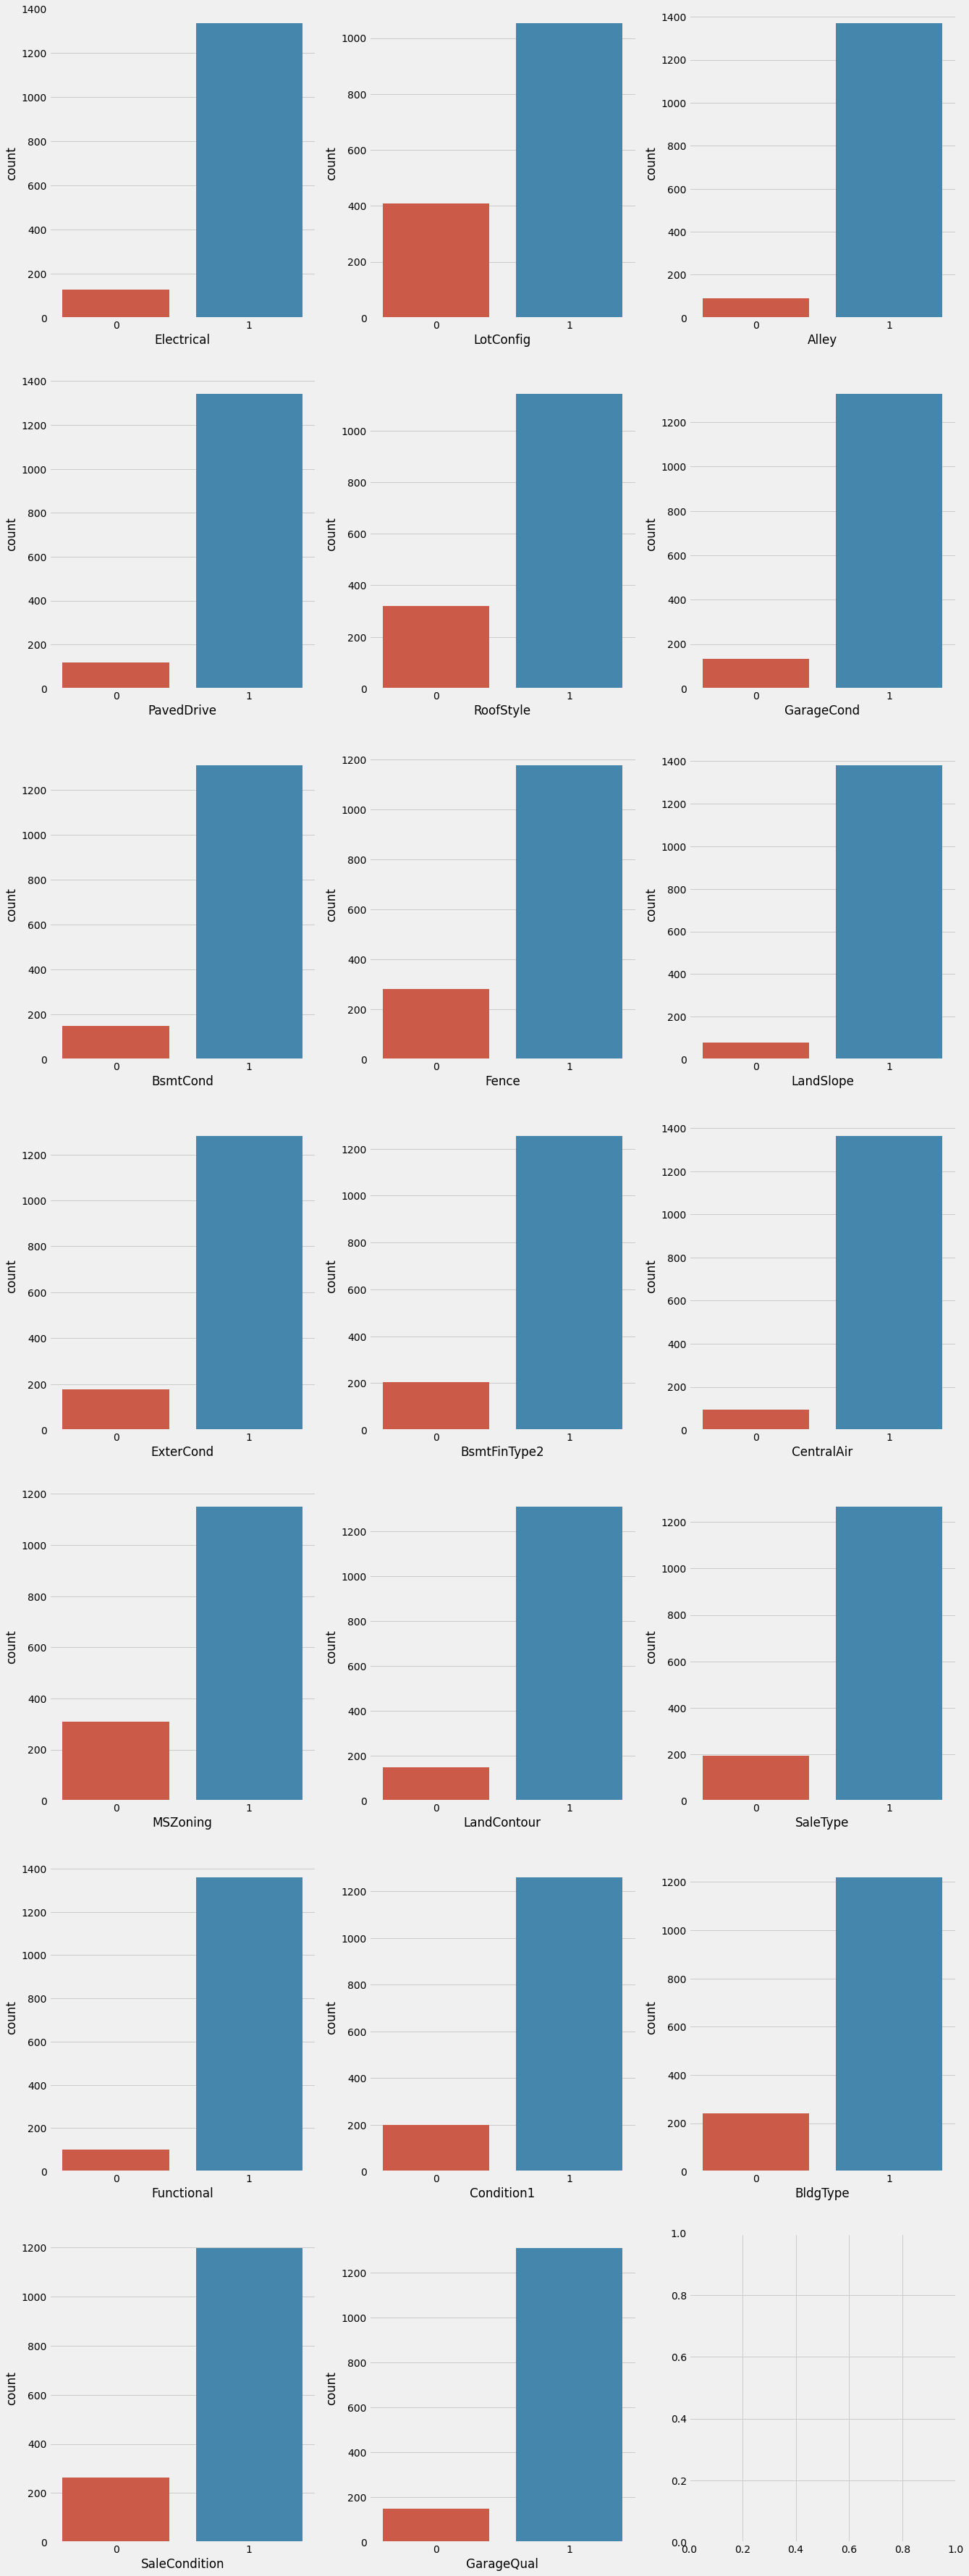

In [14]:
def dispersao_cat(df_tr, df_te,PCA):

  deletar, binario, normal = [],[],[]

  for i in df_tr:
    rt = df_tr[i].value_counts()/df_tr.shape[0]
    rt = rt[0]

    if rt >=0.95:
      deletar.append(i)
    elif (rt < 0.7):
      normal.append(i)
    else:
      binario.append(i)


  # Binário
  for i in binario:
    rt = df_tr[i].value_counts()/df_tr.shape[0]
    rt = rt.index[0]
    df_tr.loc[(df_tr[i] == rt), i] = 1
    df_tr.loc[(df_tr[i] != 1), i] = 0
    df_te.loc[(df_te[i] == rt), i] = 1
    df_te.loc[(df_te[i] != 1), i] = 0


  # Drop
  for i in deletar:
    df_tr[i] = LabelEncoder().fit_transform(df_tr[i])
    df_te[i] = LabelEncoder().fit_transform(df_te[i])

  PCA = pd.concat([PCA, pd.concat([df_tr.loc[:,deletar], df_te.loc[:,deletar]], axis=0)],axis=1)
  df_tr = df_tr.drop(deletar, axis=1)
  df_te = df_te.drop(deletar, axis=1)


  # Visualização
  figura, ax = plt.subplots(7,3, figsize=(20,60))
  plt.style.use('ggplot')

  for axi,i in zip(figura.axes, binario):
    sns.countplot(ax =axi, x = df_tr[i])

  for i in normal:
    df_tr[i] = LabelEncoder().fit_transform(df_tr[i])
    df_te[i] = LabelEncoder().fit_transform(df_te[i])
    
  return df_tr, df_te, PCA

treino_cat, teste_cat, PCA = dispersao_cat(treino_cat, teste_cat, PCA)

## PCA / Junção dos dados
- Os dados que seriam excluídos, vão ser passador pelo kernel pca para gerar um novo atríbuto com esse modelo de redução de dimensionalidade
- Os dados são agrupados em um único dataset e enviado para uso.

In [15]:
# PCA
kpca = KernelPCA(n_components=1, kernel='rbf')
pca = kpca.fit_transform(PCA)
tr_num_quan['PCA'] = pca[:tr_num_quan.shape[0]]
te_num_quan['PCA'] = pca[tr_num_quan.shape[0]:]

In [16]:
treino = pd.concat([tr_num_quan, tr_num_qual, treino_cat], axis=1 )
teste = pd.concat([te_num_quan, te_num_qual, teste_cat], axis=1 )
for i in treino:
  if treino[i].dtype == 'object':
    treino[i] = treino[i].astype(int)
    teste[i] = teste[i].astype(int)

In [17]:
treino.to_csv('/content/drive/MyDrive/Colab Notebooks/Projetos Portfólio/Regressão/Casas/Novo modelo/treino_tratado.csv', index=False)
teste.to_csv('/content/drive/MyDrive/Colab Notebooks/Projetos Portfólio/Regressão/Casas/Novo modelo/teste_tratado.csv', index=False)